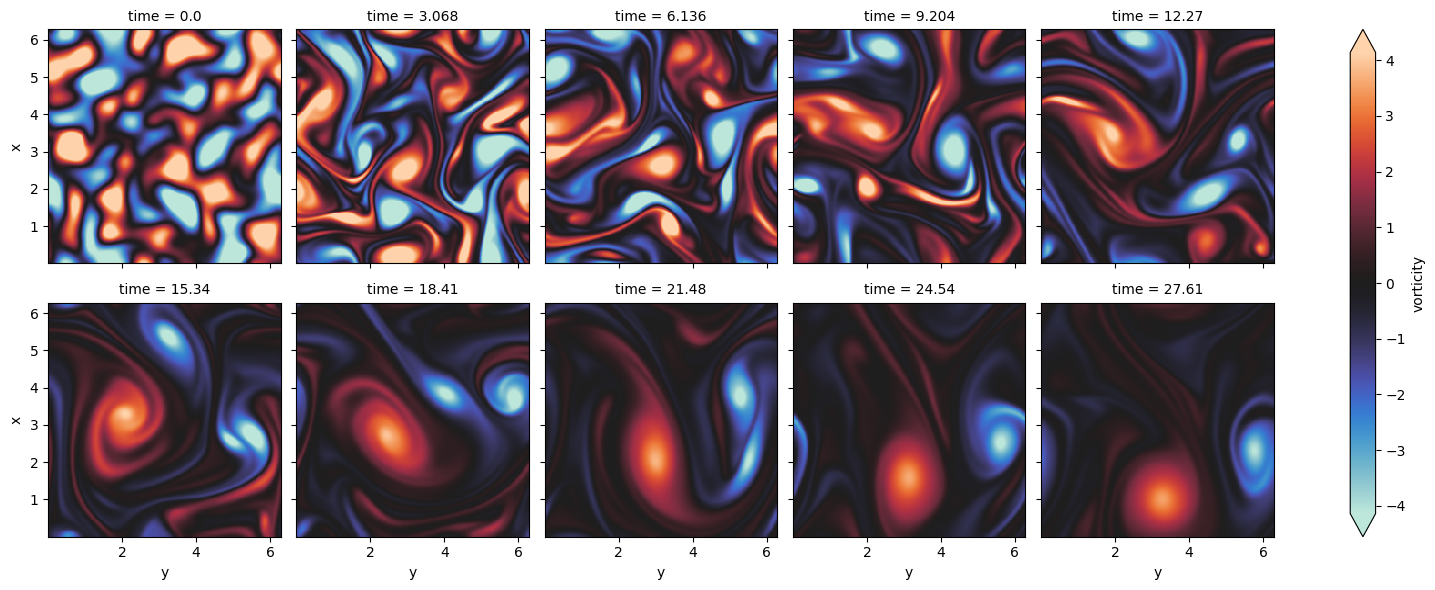

In [5]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray

size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 200

max_velocity = 2.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
time,trajectory = jax.device_get(rollout_fn(v0))



# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)
     
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

ds['vorticity'] = vorticity(ds)

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5))

     


In [12]:
import h5py

u = ds['u'].values
v = ds['v'].values
vorticity = ds['vorticity'].values
t = ds['time'].values
print(f"u.shape = {u.shape}, v.shape = {v.shape}, vorticity.shape = {vorticity.shape}, t.shape = {t.shape}")
print(f"type of u = {type(u)}, type of v = {type(v)}, type of vorticity = {type(vorticity)}, type of t = {type(t)}")
with h5py.File('data.h5', 'w') as f:
    tasks = f.create_group('tasks')
    tasks.create_dataset('u', data=u)
    tasks.create_dataset('v', data=v)
    tasks.create_dataset('vorticity', data=vorticity)

print(t)

u.shape = (200, 256, 256), v.shape = (200, 256, 256), vorticity.shape = (200, 256, 256), t.shape = (200,)
type of u = <class 'numpy.ndarray'>, type of v = <class 'numpy.ndarray'>, type of vorticity = <class 'numpy.ndarray'>, type of t = <class 'numpy.ndarray'>
[ 0.          0.15339808  0.30679616  0.46019424  0.61359232  0.76699039
  0.92038847  1.07378655  1.22718463  1.38058271  1.53398079  1.68737887
  1.84077695  1.99417502  2.1475731   2.30097118  2.45436926  2.60776734
  2.76116542  2.9145635   3.06796158  3.22135965  3.37475773  3.52815581
  3.68155389  3.83495197  3.98835005  4.14174813  4.29514621  4.44854428
  4.60194236  4.75534044  4.90873852  5.0621366   5.21553468  5.36893276
  5.52233084  5.67572892  5.82912699  5.98252507  6.13592315  6.28932123
  6.44271931  6.59611739  6.74951547  6.90291355  7.05631162  7.2097097
  7.36310778  7.51650586  7.66990394  7.82330202  7.9767001   8.13009818
  8.28349625  8.43689433  8.59029241  8.74369049  8.89708857  9.05048665
  9.203884